# Online Store Business Decision Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

In [3]:
# read the csv file
try:
    hypo = pd.read_csv('hypotheses_us.csv', sep=';')
    orders = pd.read_csv('orders_us.csv')
    visits = pd.read_csv('visits_us.csv')
except:
    hypo = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
    orders = pd.read_csv('/datasets/orders_us.csv')
    visits = pd.read_csv('/datasets/visits_us.csv')

In [4]:
def data_info(data):
    """This function helps simplify reading multiple datasets.
    
    This function takes the dataset variable as input and 
    produces the general information about each dataset, 
    including description, duplicates and missing values."""
    print('General dataset information:')
    print(data.info())
    print()
    print('First five rows:')
    print(data.head())
    print()
    print('Description of the dataset:')
    print(data.describe())
    print()
    print('This dataset has {} duplicates.'.format(data.duplicated().sum()))
    print()
    print('How many missing values does this data have?')
    print(data.isna().sum())
    print()
    print('What is the percentage of the missing values?')
    print(data.isna().sum() / len(data))

## Introduction
<a name="introduction"></a>

Three datasets have been provided for A/B test analysis from an online store. The report will examine:
1. A list of hypotheses to increase sales provided by marketing department for prioritisation.
2. Visits and orders in the online store between August 1-31, 2019, for comparison of the cumulative revenue, average purchase size, and conversion rates between the Group A and Group B.
3. The statistical significance test of the order data, both raw and filtered.

Based on the test results and conclusions drawn in this report, we can make a decision to either continue the test or stop the test, and to see whether any group is leading over the other.

### Table of contents
1. [Introduction](#introduction)
2. [Prioritising Hypotheses](#hypo)
3. [A/B Testing](#abtest)
4. [Outliers and Surges](#outliers)
5. [Statistical Significance Testing](#stats)
5. [Conclusion](#conclusion)

In [5]:
data_info(hypo)

General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None

First five rows:
                                          Hypothesis  Reach  Impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   

   Confidence  Effort  
0           8       6  
1           4      10  
2           7 

In [6]:
data_info(orders)

General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None

First five rows:
   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     30.4     B
1     2804400009  3642806036  2019-08-15     15.2     B
2     2961555356  4069496402  2019-08-15     10.2     A
3     3797467345  1196621759  2019-08-15    155.1     B
4     2282983706  2322279887  2019-08-15     40.5     B

Description of the dataset:
       transactionId     visitorId       revenue
count   1.197000e+03  1.197000e+03   1197.000000
mean    

In [7]:
data_info(visits)

General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None

First five rows:
         date group  visits
0  2019-08-01     A     719
1  2019-08-02     A     619
2  2019-08-03     A     507
3  2019-08-04     A     717
4  2019-08-05     A     756

Description of the dataset:
           visits
count   62.000000
mean   607.290323
std    114.400560
min    361.000000
25%    534.000000
50%    624.500000
75%    710.500000
max    770.000000

This dataset has 0 duplicates.

How many missing values does this data have?
date      0
group     0
visits    0
dtype: int64

What is the percentage of the missing values?
date      0.0
group     0.0
visits    0.0
dtype: float64


From the initial look at the datasets, we didn't find any missing values or duplicates. But some things can be done to optimise the data for analysis, such as changing the column names formatting and changing the data type.

### Data Preprocessing

In [8]:
hypo.columns = hypo.columns.str.lower()

In [9]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

In [10]:
visits['date'] = pd.to_datetime(visits['date'], format='%Y-%m-%d')
visits['visits'] = visits['visits'].astype('int')

In [11]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [12]:
print('Number of unique users in the data:', orders['visitorId'].nunique())
print('Number of unique users in group A:', orders[orders['group'] == 'A']['visitorId'].nunique())
print('Number of unique users in group B:', orders[orders['group'] == 'B']['visitorId'].nunique())
print('Total of users in both groups:', orders[orders['group'] == 'A']['visitorId'].nunique() + orders[orders['group'] == 'B']['visitorId'].nunique())

Number of unique users in the data: 1031
Number of unique users in group A: 503
Number of unique users in group B: 586
Total of users in both groups: 1089


There are 640 entries for group B, and 557 for A group. However, when we look at how many unique visitorId in each group and compare it with total visitorId, we can notice that the sum of both groups is larger than the total unique visitorId number. This means there are users who mistakenly being put in both groups, before doing anything about it, we will check how many of them are there.

In [13]:
usersA = orders[orders['group'] =='A']['visitorId'].unique()
usersB = orders[orders['group'] =='B']['visitorId'].unique()
usersAB = np.intersect1d(usersA, usersB)
print('Number of users belonging to both groups is', len(usersAB))

Number of users belonging to both groups is 58


In [14]:
len(orders[orders['visitorId'].isin(usersAB)]) / len(orders['visitorId'])

0.15121136173767752

There are 58 users that actually show up in both A and B groups, accounting to 15% of the total data. It's quite a big percentage but we need to filter them to avoid skewed analysis.

In [15]:
orders = orders[~orders['visitorId'].isin(usersAB)]
orders['group'].value_counts()

B    548
A    468
Name: group, dtype: int64

In this section, we have imported, examined and preprocessed the datasets. We changed the data types in the data to the correct one, such as integer and datetime, and changed the column to lowercase. We also removed the rows where users are being put in both group A and group B. The resulting dataset contains 468 users in group A and 548 users in group B. We might need to remove outliers and surges after further analysis.

## Prioritising Hypotheses
<a name="hypo"></a>

For prioritising the 9 proposed hypotheses, we will use ICE (Impact, Confidence and Effort parameters) and RICE (Reach, Impact, Confidence and Effort parameters) formula.

In [16]:
pd.set_option('display.width', 1000)

In [17]:
hypo['ice'] = (hypo['impact'] * hypo['confidence']) / hypo['effort']

In [18]:
hypo[['hypothesis', 'ice']].sort_values('ice', ascending=False)

,hypothesis,ice
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


Top 3 hypotheses calculated with ICE formula are the **9th**, **1st** and **8th** hypotheses. 

In [19]:
hypo['rice'] = (hypo['reach'] * 
                hypo['impact'] *
                hypo['confidence']) / hypo['effort']

In [20]:
hypo[['hypothesis', 'rice']].sort_values('rice', ascending=False)

,hypothesis,rice
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


Top 3 hypotheses calculated with RICE formula are the **8th**, **3rd** and **1st** hypotheses. 

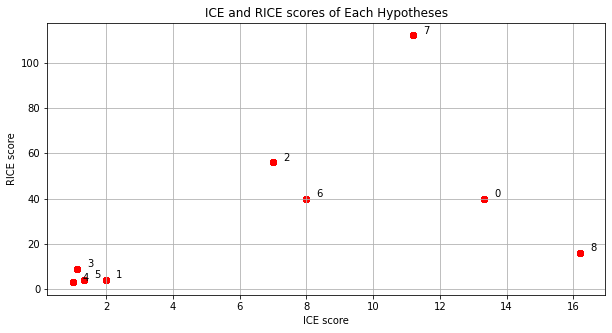

In [44]:
x = hypo['ice']
y = hypo['rice']
thesis = hypo.index

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x, y)
ax.grid()
ax.set_title('ICE and RICE scores of Each Hypotheses')
ax.set_xlabel('ICE score')
ax.set_ylabel('RICE score')

for i, txt in enumerate(thesis):
    ax.annotate(txt, (x[i], y[i]), xytext=(10, 2), textcoords='offset points')
    plt.scatter(x, y, color='red')

On the scatterplot, the hypotheses that is shown on the most top and right, would be the one that will ensure maximum growth of key business metrics. We can see that 8th hypotheses score highest on RICE and 9th scores highest on ICE, while the 3rd and 1st are scoring second on RICE and ICE, respectively. The 7th hypotheses is in the top 5 for both ICE and RICE.

#### Conclusion

- The 8th hypotheses scores the highest on RICE, and 3rd on ICE - adding a subscription button to main pages in fact will reach a lot of customers, and to add them will only require the developers to change the main pages. 
- The 1st hypotheses scores 2nd on ICE and 3rd on RICE - adding new channels may bring more traffic, but it would also be cost intensive. 
- The 9th hypotheses scores high on ICE but dropped to 5th position on RICE as the reach would be really low, as a customer will only have birthday once a year.

Therefore for this project, the 8th hypotheses should be prioritised.

## A/B Testing
<a name="abtest"></a>

To prevent the peeking problem, we will analyse the graphs of cumulative revenue and purchase size of the visit and order data from August 1 to August 31, 2019.

In [45]:
datesGroups = orders[['date', 'group']].drop_duplicates()

In [46]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders[
        'group'] == x['group'])].agg({
            'date': 'max',
            'group': 'max',
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue': 'sum'
        }),
    axis=1).sort_values(by=['date', 'group'])

In [47]:
visitorsAggregated = datesGroups.apply(
    lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits[
        'group'] == x['group'])].agg({
            'date': 'max',
            'group': 'max',
            'visits': 'sum'
        }),
    axis=1).sort_values(by=['date', 'group'])

### Cumulative Revenue of Each Group

In [48]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [49]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

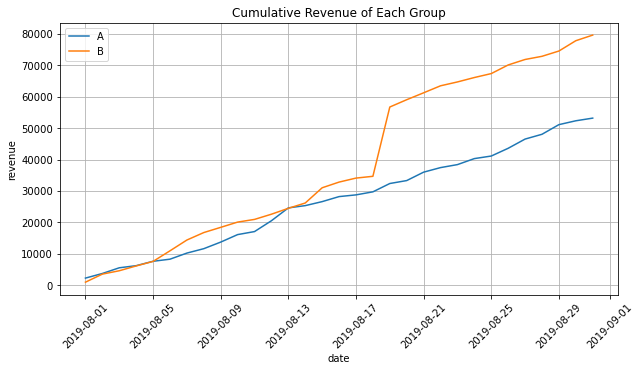

In [50]:
plt.figure(figsize=(10,5))
plt.grid()

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Cumulative Revenue of Each Group')
#plt.axis(['2019-08-01', '2019-08-31', -0.1, 0.5])
plt.xlabel('date')
plt.ylabel('revenue')
plt.xticks(rotation=45)
plt.legend();

The graph shows the cumulative revenue for group A and B. Until around August 18, they were increasing about the same rate, afterwards group B's revenue increased around \\$20000 and maintain the lead for the rest of the month. There might be a large purchase happening on that day in group B that caused the sudden hike, as the increase rate stabilises and matches group A again. We will address the outlier further below.

### Average Purchase Size of Each Group

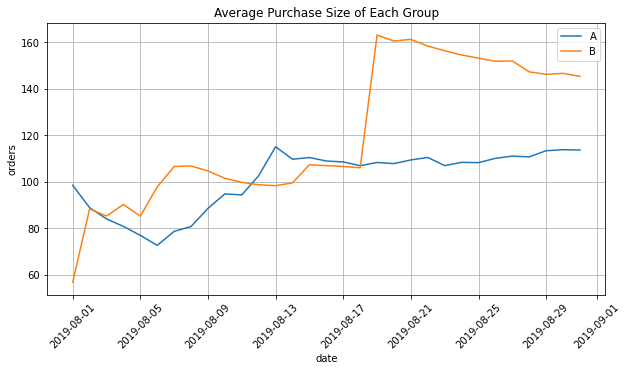

In [51]:
plt.figure(figsize=(10,5))
plt.grid()

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('Average Purchase Size of Each Group')
plt.xlabel('date')
plt.ylabel('orders')
plt.xticks(rotation=45)
plt.legend();

At the beginning of the month, both groups have different fluctuations. Slow decrease for group A until August 6 before increasing until August 13, afterwards the order stabilises between 100-120 orders until the end of the month.
While group B saw an increase on the first week, until it stabilises up to the sudden spike on August 18, before decreasing slowly right after from 160 to 140. 

#### Relative Difference of Average Purchase Size

In [52]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

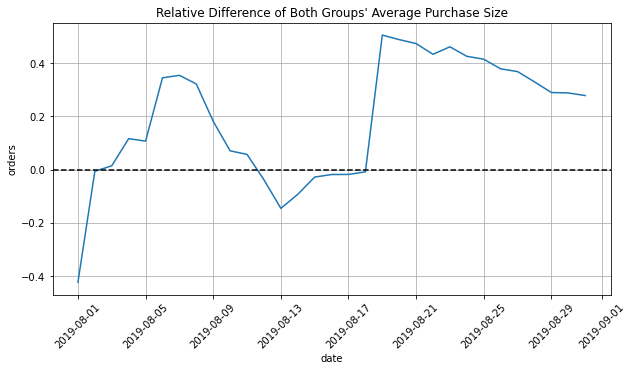

In [53]:
plt.figure(figsize=(10,5))
plt.grid()

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')

plt.title("Relative Difference of Both Groups' Average Purchase Size")
plt.xlabel('date')
plt.ylabel('orders')
plt.xticks(rotation=45);

In the relative difference graph, most of the time group B is leading over group A, except the first couple of days and on August 13. The suspected outlier influences the relative difference as well, causing a large spike above 0.4 before decreasing towards the end of the month. The decrease suggests that if we remove the outliers, we might see some relative losses after August 18.

### Conversion

#### Daily Conversion

In [54]:
order_grouped = orders.groupby(['group', 'date']).agg({'transactionId': 'count'}).reset_index()
order_grouped.columns=['group', 'date', 'orders']
conversion = order_grouped.merge(visits, on=['group', 'date'])
conversion['conversion'] = conversion['orders'] / conversion['visits']

In [55]:
conversionA = conversion[conversion['group'] == 'A']
conversionB = conversion[conversion['group'] == 'B']

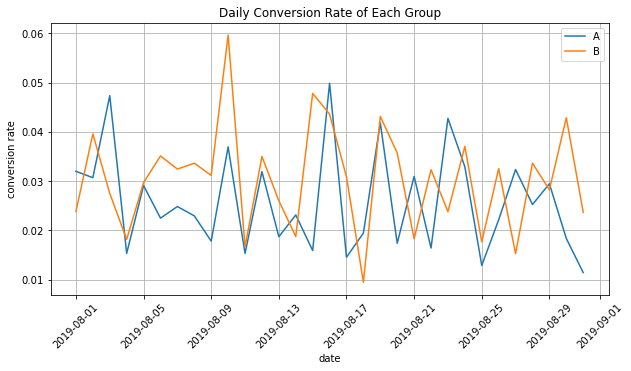

In [56]:
plt.figure(figsize=(10,5))
plt.grid()

plt.plot(conversionA['date'], conversionA['conversion'], label='A')
plt.plot(conversionB['date'], conversionB['conversion'], label='B')

plt.title('Daily Conversion Rate of Each Group')
plt.xlabel('date')
plt.ylabel('conversion rate')
plt.xticks(rotation=45)
plt.legend();

From the line graph, we cannot see any obvious pattern as both groups fluctuate strongly throughout the month. Group B has the lowest conversion rate (1%) on August 18 and highest conversion rate (6%) on August 10, 2019.

In [57]:
merged_conversion = conversionA[['date','conversion']].merge(conversionB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

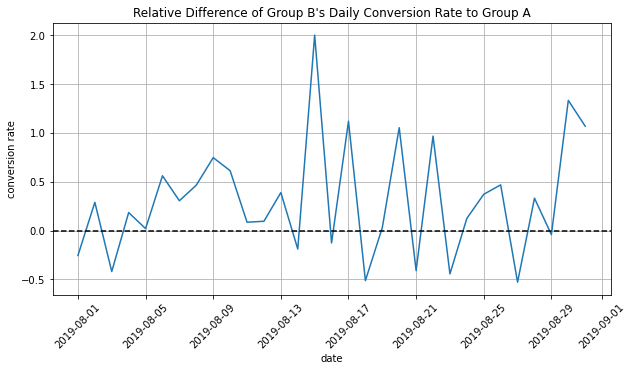

In [58]:
plt.figure(figsize=(10,5))
plt.grid()

plt.plot(merged_conversion['date'], merged_conversion['conversionB'] / merged_conversion['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
#plt.axis(['2019-08-01', '2019-08-31', -0.6, 0.6])

plt.title("Relative Difference of Group B's Daily Conversion Rate to Group A")
plt.xlabel('date')
plt.ylabel('conversion rate')
plt.xticks(rotation=45);

On the graph above, we can see that group B mostly has relative gains over group A, although it's not stable throughout the month. We can inspect further on the cumulative conversion rate below. 

In [59]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

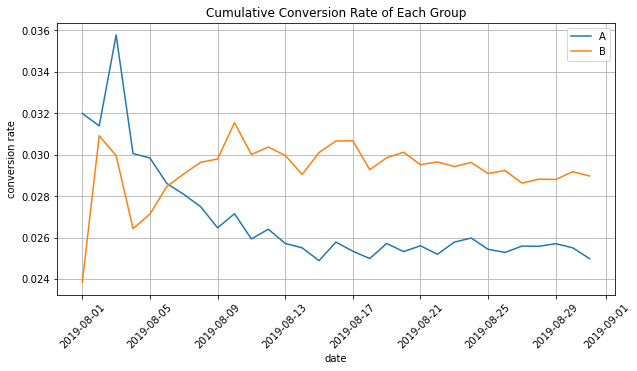

In [60]:
plt.figure(figsize=(10,5))
plt.grid()

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title("Cumulative Conversion Rate of Each Group")
plt.xlabel('date')
plt.ylabel('conversion rate')
plt.xticks(rotation=45)
plt.legend();

On the cumulative conversion graph, at the beginning group A has higher conversion rate but continues to drop throughout the month. Meanwhile, group B starts pretty low, saw an increase, then stabilises. It is interesting to see that the pattern of both groups are quite similar, they both have a spike on conversion rate around August 2-3 then the spike dropped on the 4th and stabilised from August 9 onwards.

In [61]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

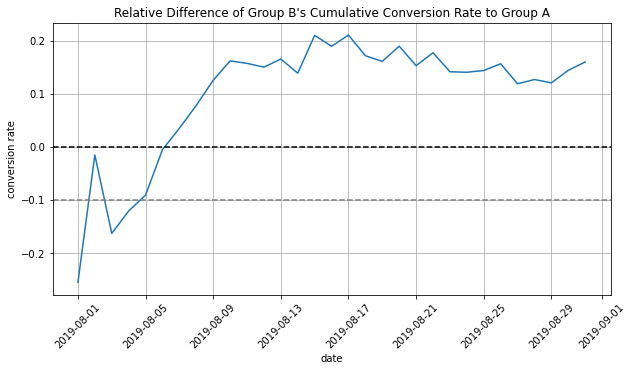

In [62]:
plt.figure(figsize=(10,5))
plt.grid()

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Relative gain in conversion in group B as opposed to group A")

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.title("Relative Difference of Group B's Cumulative Conversion Rate to Group A")
plt.xlabel('date')
plt.ylabel('conversion rate')
plt.xticks(rotation=45);

In the relative difference graph, group B has relative gains over group A from August 6 onwards, despite starting pretty low, even the spike cannot give it enough gains to lead.

#### Conclusion

In this section we have examined the difference in revenue, average purchase size and conversion rate between group A and B. We have found that:
- group B is leading in cumulative revenue and purchase size over group A, although it might be caused by an outlier, that we should inspect further.
- group B is leading in conversion rate over group A, despite group A's initial lead.

## Outliers and Surges
<a name="outliers"></a>

### Revenue

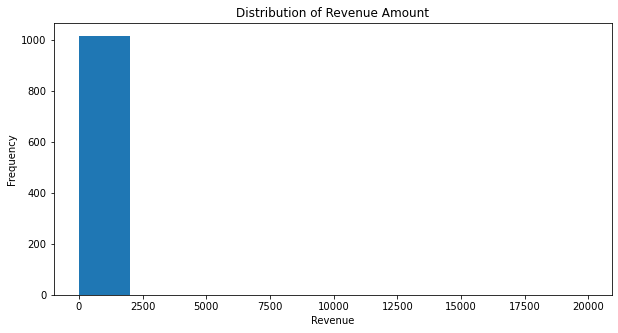

In [63]:
plt.figure(figsize=(10,5))
plt.hist(orders['revenue'])
plt.title('Distribution of Revenue Amount')
plt.xlabel('Revenue')
plt.ylabel('Frequency');

In the histogram above, we can't really see anything above \\$2500, which means they are most likely just outliers.

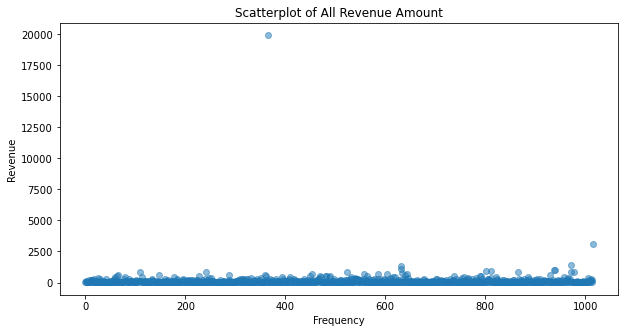

In [64]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(10,5))

plt.scatter(x_values, orders['revenue'], alpha=0.5) 
plt.title('Scatterplot of All Revenue Amount')
plt.xlabel('Frequency')
plt.ylabel('Revenue');

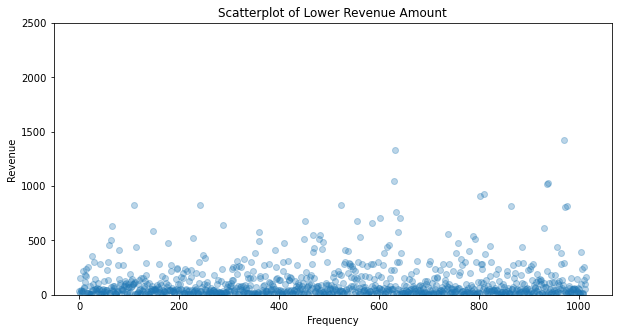

In [65]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(10,5))

plt.scatter(x_values, orders['revenue'], alpha=0.3) 
plt.ylim(0, 2500)
plt.title('Scatterplot of Lower Revenue Amount')
plt.xlabel('Frequency')
plt.ylabel('Revenue');

On the first scatterplot, we can see a couple of dots above \\$2500 and another one at \\$20000. The rest are mostly under \\$1000. The second scatterplot shows that most of the revenue are concentrated below \\$500. We can see on the percentile how much revenue amount that mostly occurs. 

In [66]:
np.percentile(orders['revenue'], [90, 95, 99])

array([280.8  , 414.275, 830.3  ])

Based on the percentile, 95% of the revenue are \\$414.275 and below, and 99\% of the revenue are \\$830 and below.

### Order Per User

In [67]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({
    'transactionId': pd.Series.nunique,
    'group':'max'})
ordersByUsers.columns=['visitorId', 'orders', 'group']

In [68]:
print(ordersByUsers.sort_values(by='orders', ascending=False).head())

      visitorId  orders group
908  3967698036       3     A
55    249864742       3     B
478  2108163459       3     A
687  2988190573       3     A
890  3908431265       3     A


In [69]:
orderA = ordersByUsers[ordersByUsers['group'] == 'A']['orders']
orderB = ordersByUsers[ordersByUsers['group'] == 'B']['orders']

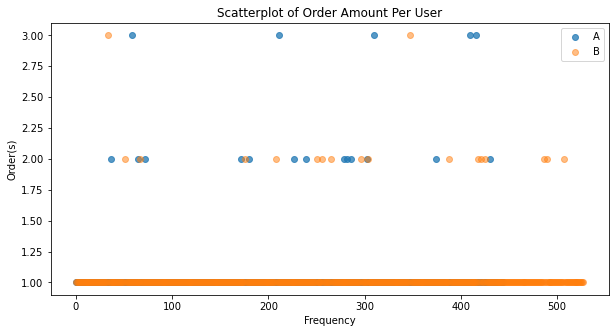

In [70]:
plt.figure(figsize=(10, 5))

x_values_A = pd.Series(range(0, len(ordersByUsers[ordersByUsers['group'] == 'A']['orders'])))
x_values_B = pd.Series(range(0, len(ordersByUsers[ordersByUsers['group'] == 'B']['orders'])))

plt.scatter(x_values_A, orderA, label='A', alpha=0.75)
plt.scatter(x_values_B, orderB, label='B', alpha=0.5)

plt.title('Scatterplot of Order Amount Per User')
plt.ylabel('Order(s)')
plt.xlabel('Frequency')
plt.legend();

In [71]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Based on the scatterplot, most of the users are only making 1 order, the 2 orders are scarce and only 7 users make 3 orders. 5 of those 7 are from group A.

#### Conclusion

In this section we have analysed the orders data for outliers. We found some outliers in the revenue up to \\$20000, that might cause a skewed analysis. We also found that most users place 1 order costing below \\$830.

## Test of Statistical Significance
<a name="stats"></a>

On the next section, we will test if group A and B have the same conversion rates. 

1. Null and Alternative Hypotheses

H0: The means of two statistical populations are equal. In this case it means that the conversion rates of group A is the same as group B.

H1: The means of two statistical populations are not equal. In this case it means that the conversion rates of group A is not the same as group B.

2. Criteria for a decision (alpha value)
In behavioral science, the level of significance is typically set at 5% and we will choose this criteria as well. When the probability of obtaining a sample mean is less than 5% if the null hypothesis were true, then we reject the value stated in the null hypothesis.

3. Calculate the test
In order to test our hypotheses that the means of two statistical populations are equal based on samples taken from them, we will apply the Mann Whitney U test.

### Raw Data

#### Conversion Rates Difference

In [72]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

In [73]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [74]:
print("{0:.5%}".format(st.mannwhitneyu(sampleA, sampleB)[1], alternative='two-sided'))
print("{0:.3%}".format(sampleB.mean()/sampleA.mean()-1)) 

0.55090%
15.980%


The p-value is smaller than the alpha (5%). Therefore we reject the null hypothesis. We can conclude that there is a difference in conversion rates between the two groups. The relative gains of group B is 13.8%.

#### Average Purchase Size Difference

For the next section, we will see the average purchase size of each group.

1. Null and Alternative Hypotheses

H0: The means of two statistical populations are equal. In this case it means that the average purchase size of group A is the same as group B.

H1: The means of two statistical populations are not equal. In this case it means that the average purchase size of group A is not the same as group B.

In [75]:
revenueA = orders[orders['group'] == 'A']['revenue']
revenueB = orders[orders['group'] == 'B']['revenue']

In [76]:
print("{0:.2%}".format(st.mannwhitneyu(revenueA, revenueB)[1], alternative='two-sided'))
print("{0:.2%}".format(revenueB.mean() / revenueA.mean() - 1))

43.11%
27.83%


The p-value is bigger than the alpha (5%). Therefore we retain the null hypothesis. We can conclude that there is no difference in average purchase size between the two groups. Although, we can see that the relative gains of group B is 25.1%. This might be caused by the outlier on the data, therefore on the next section we will filter the outlier.

### Filtered Data

Based on the percentile calculation, the 99% of all revenue is \\$830 and below. We will use that number to filter out the outlier.

In [77]:
usersWithExpensiveOrders = orders[orders['revenue'] > 830]['visitorId']
len(usersWithExpensiveOrders)

12

There are 18 transactions above \\$830 that account to 1% of all transactions.

#### Conversion Rates Difference

In [78]:
filteredSampleA = pd.concat(
    [ordersByUsersA[~ordersByUsersA['visitorId'].isin(usersWithExpensiveOrders)]['orders'], 
     pd.Series(0, index=np.arange(visits[visits['group'] == 'A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')], 
    axis=0)

filteredSampleB = pd.concat(
    [ordersByUsersB[~ordersByUsersB['visitorId'].isin(usersWithExpensiveOrders)]['orders'], 
     pd.Series(0, index=np.arange(visits[visits['group'] == 'B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')], 
    axis=0)

In [79]:
print("{0:.3%}".format(st.mannwhitneyu(filteredSampleA, filteredSampleB)[1], alternative='two-sided'))
print("{0:.2%}".format(filteredSampleB.mean() / filteredSampleA.mean() - 1))

0.436%
16.65%


The p-value is smaller than the alpha (0.05). Therefore we reject the null hypothesis. We can conclude that there is a difference in conversion rates between the two filtered groups. The relative gains of filtered group B is 15%, which is similar to the raw data.

In [80]:
filteredRevenueA = orders[(orders['group'] == 'A') & (~orders['visitorId'].isin(usersWithExpensiveOrders))]['revenue']
filteredRevenueB = orders[(orders['group'] == 'B') & (~orders['visitorId'].isin(usersWithExpensiveOrders))]['revenue']

In [81]:
print("{0:.2%}".format(st.mannwhitneyu(filteredRevenueA, filteredRevenueB)[1], alternative='two-sided'))
print("{0:.2%}".format(filteredRevenueB.mean() / filteredRevenueA.mean()-1))

49.42%
-1.41%


The p-value is bigger than the alpha (5%). Therefore we retain the null hypothesis. We can conclude that there is no difference in average purchase size between the two filtered groups. Although, now filtered group B is showing a slight relative loss of 1.1% over filtered group A.

## Overall Conclusion
<a name="conclusion"></a>

1. We have analysed three datasets from the online store, first is a list of hypotheses, the second is server log for online store visits and the third is transaction data from the online store orders.
2. We have preprocessed the data by optimising it for analysis, changing the data types and finding error such as there are 58 users that is being put on both group A and B. This is a lot of users that we need to filter out from the datasets, around 15% of total transaction, therefore on the next A/B test we need to be more careful with how to group the users.
3. We have prioritised the hypotheses using ICE and RICE formula. We found that the 9th hypotheses *"Add a subscription form to all the main pages"* is the most fitting for this project, as it will reach a lot of customers while not consuming a lot of resources and time.
4. We have analysed the result of the A/B test, through raw and filtered data. We found that:
- group B is leading on the conversion rates, both on raw and filtered data.
- group B is initially leading on the average purchase size, although later we found that this was caused by some outliers in the data. After the data is filtered, group A is slightly leading over group B.